Imports

In [2]:
# !pip install scipy==1.6.0
# !pip install matplotlib==3.1.0

In [1]:
import os, json, random
random.seed(1)
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display, Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# AIF360
import aif360
from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
# fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric, DatasetMetric
from aif360.metrics.common_utils import compute_metrics
from aif360.metrics.utils import compute_num_instances
# data preprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
# explainers
from aif360.explainers import MetricTextExplainer
# bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover, GerryFairClassifier
from aif360.sklearn.inprocessing import AdversarialDebiasing as SKLearnAdversarialDebiasing
from aif360.algorithms.inprocessing.gerryfair.clean import array_to_tuple
from aif360.algorithms.inprocessing.gerryfair.auditor import Auditor
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.sklearn.utils import check_inputs, check_groups

In [3]:
# TensorFlow
import tensorflow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [4]:
import sklearn
# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree, linear_model
# metrics
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix
# kernels
from sklearn.kernel_ridge import KernelRidge

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.datasets import make_blobs
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance

Helper Functions

In [5]:
FILES = '/Users/megantennies/FYP/saved data'

In [6]:
def save_to_json(filename, data):
    with open(os.path.join(FILES, filename), 'w') as write:
        json.dump(data, write)

In [7]:
def json_to_df(filename):
    with open(filename, 'r') as load:
        data = json.load(load)
    df = pd.DataFrame(data)
    return df

In [8]:
def df_to_json(filename, df):
    df.to_json(os.path.join(FILES, filename), orient = 'split', 
    compression = 'infer', index = True)

In [9]:
def plot_metric_graphs(metric_name, filename):
    pass

Data

In [10]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
original_dataset = load_preproc_data_compas(['race'])

In [11]:
default_mappings = {'label_maps': [{1.0: 'Recid', 0.0: 'Non-Recid'}], 
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, 
    {1.0: 'White', 0.0: 'Non-White'}]}
metrics = ['Statistical parity difference', 'Average odds difference', 
    'Equal opportunity difference']

In [12]:
original_train, original_val_test = original_dataset.split([0.7], shuffle = True)
original_val, original_test = original_val_test.split([0.5], shuffle = True)

In [13]:
def describe(train = None, val = None, test = None):
    if train is not None:
        display(Markdown('#### Training dataset shape'))
        print(train.features.shape)
    if val is not None:
        display(Markdown('#### Validation dataset shape'))
        print(val.features.shape)
    display(Markdown('#### Test dataset shape'))
    print(test.features.shape)
    display(Markdown('#### Favorable and unfavorable labels'))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown('#### Protected attribute names'))
    print(test.protected_attribute_names)
    display(Markdown('#### Privileged and unprivileged protected attribute values'))
    print(test.privileged_protected_attributes, test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(train.feature_names)

In [14]:
describe(original_train, original_val, original_test)

#### Training dataset shape

(3694, 10)


#### Validation dataset shape

(792, 10)


#### Test dataset shape

(792, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [15]:
original_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [16]:
original_explainer = MetricTextExplainer(original_metric)
display(Markdown('#### Original COMPAS training data'))

original_train_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Training data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_train_metric.mean_difference())

original_val_metric = BinaryLabelDatasetMetric(original_val, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Validation data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_val_metric.mean_difference())

original_test_metric = BinaryLabelDatasetMetric(original_test, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Testing data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_test_metric.mean_difference())

#### Original COMPAS training data

Training data: Difference in mean outcomes between unprivileged and privileged groups = -0.131862
Validation data: Difference in mean outcomes between unprivileged and privileged groups = -0.120425
Testing data: Difference in mean outcomes between unprivileged and privileged groups = -0.146916


LR

In [17]:
original_scaler = StandardScaler()
X_train = original_scaler.fit_transform(original_train.features)
y_train = original_train.labels.ravel()
w_train = original_train.instance_weights.ravel()

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train, sample_weight = original_train.instance_weights)
y_train_preds = lr.predict(X_train)

In [19]:
pos_ind = np.where(lr.classes_ == original_train.favorable_label)[0][0]

In [20]:
original_train_preds = original_train.copy()
original_train_preds.labels = y_train_preds

original_val_preds = original_val.copy(deepcopy = True)
X_val = original_scaler.transform(original_val_preds.features)
y_val = original_val_preds.labels
original_val_preds.scores = lr.predict_proba(X_val)[:, pos_ind].reshape(-1, 1)

original_test_preds = original_test.copy(deepcopy = True)
X_test = original_scaler.transform(original_test_preds.features)
y_test = original_test_preds.labels
original_test_preds.scores = lr.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

In [21]:
num_thresh = 100
bal_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    fav_inds = original_val_preds.scores > class_thresh
    original_val_preds.labels[fav_inds] = original_val_preds.favorable_label
    original_val_preds.labels[~fav_inds] = original_val_preds.unfavorable_label

    original_val_metric = ClassificationMetric(original_val, 
        original_val_preds, unprivileged_groups = unprivileged_groups, 
        privileged_groups = privileged_groups)

    bal_arr[idx] = 0.5 * (original_val_metric.true_positive_rate() 
        + original_val_metric.true_negative_rate())

In [22]:
best_ind = np.where(bal_arr == np.max(bal_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown('#### Original COMPAS data'))
print('Best balanced accuracy (no transforming): %.4f' % np.max(bal_arr))
print('Optimal classification threshold (no transforming): %.4f' % best_class_thresh)

#### Original COMPAS data

Best balanced accuracy (no transforming): 0.6383
Optimal classification threshold (no transforming): 0.5643


In [34]:
bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
eq_opp_diff_arr = []
outcome_unfair_arr = []
acc_equal_arr = []

In [35]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = original_test_preds.scores > thresh
    original_test_preds.labels[fav_inds] = original_test_preds.favorable_label
    original_test_preds.labels[~fav_inds] = original_test_preds.unfavorable_label
    
    metric_test = compute_metrics(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    class_metric_test = ClassificationMetric(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups)
    
    bal_acc_arr.append(metric_test['Balanced accuracy'])
    avg_odds_diff_arr.append(metric_test['Average odds difference'])
    disp_imp_arr.append(metric_test['Disparate impact'])
    eq_opp_diff_arr.append(metric_test['Equal opportunity difference'])
    outcome_unfair_arr.append(class_metric_test.false_discovery_rate_difference() \
        + class_metric_test.false_positive_rate_difference())
    acc_equal_arr.append((class_metric_test.true_positive_rate(privileged = False) + \
        class_metric_test.true_negative_rate(privileged = False)) - \
            (class_metric_test.true_positive_rate(privileged = True) + \
                class_metric_test.true_negative_rate(privileged = True)))

#### Predictions from the original testing data

 69%|██████▉   | 69/100 [00:00<00:00, 315.73it/s]

Classification threshold used: 0.4258
Balanced accuracy = 0.6605
Statistical parity difference = -0.2801
Disparate impact = 0.6556
Average odds difference = -0.2425
Equal opportunity difference = -0.2173
Theil index = 0.1652


invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 361.95it/s]


In [39]:
LR_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr)
LR_acc_equal = np.interp(best_class_thresh, class_thresh_arr, acc_equal_arr)
LR_disp_imp = np.interp(best_class_thresh, class_thresh_arr, disp_imp_arr)
LR_out_unf = np.interp(best_class_thresh, class_thresh_arr, outcome_unfair_arr)
LR_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr)
LR_eq_odds = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr)

In [40]:
LR_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Logistic Regression': [LR_bal_acc, LR_acc_equal, LR_disp_imp, LR_out_unf, LR_avg_odds, LR_eq_odds]}
LR_results_df = pd.DataFrame(LR_results)
LR_results_df

,Metric,Logistic Regression
0,Balanced Accuracy,0.660480
1,Accuracy Equality,0.050261
2,Disparate Impact,0.655639
3,Outcome Unfairess,-0.196279
4,Average Odds Difference,-0.242456
5,Equal Opportunity Difference,-0.217325


In [46]:
df_to_json(filename = 'LR_results.json', df = LR_results_df)

AD

In [23]:
# session.close()
# tf.reset_default_graph()
session = tf.Session()

In [24]:
X, y = fetch_compas(binary_race = True)
X.index = pd.MultiIndex.from_arrays(X.index.codes, names = X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names = y.index.names)
y = 1 - pd.Series(y.factorize(sort = True)[0], index = y.index)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234567)
data_preproc = make_column_transformer((OneHotEncoder(sparse = False, handle_unknown = 'ignore'), 
        X_train.dtypes == 'category'), remainder = StandardScaler())
X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index = X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index = X_test.index)

In [26]:
def find_loss_weights(loss_weights):
    weights = {'Adversarial Loss Weight': [], 'Mean Accuracy': []}
    for weight in loss_weights:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', adversary_loss_weight = weight)
        ad = ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        weights['Adversarial Loss Weight'].append(weight)
        weights['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(weights)

In [27]:
loss_weights = [i for i in np.linspace(0.01, 1.0, 20)]
weights = find_loss_weights(loss_weights = loss_weights)

In [28]:
def plot_params(param, metric, param_data, best_x, best_y, title, file_name):
    plt.figure(figsize = (10, 7))
    ax = sns.lineplot(x = param, y = metric, data = param_data, color = '#348149')
    if param == 'Adversarial Loss Weight':
        ax.annotate(s = ' x = {:.2f}, y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    elif param == 'Number of Hidden Units':
        ax.annotate(s = ' x = {:}, \n y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    sns.set_style('whitegrid')
    plt.title(title)
    plt.savefig(file_name, bbox_inches = 'tight')

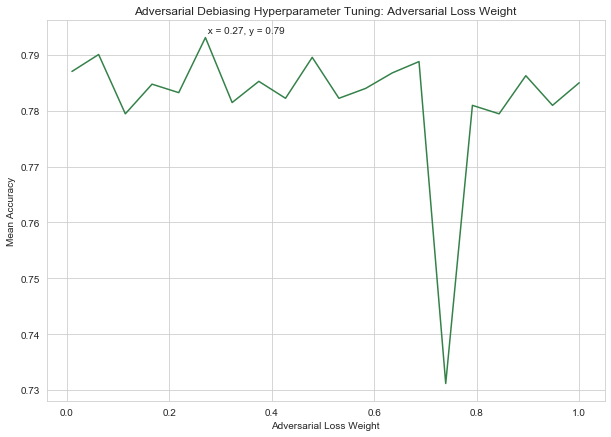

In [38]:
plot_params(param = 'Adversarial Loss Weight', metric = 'Mean Accuracy', 
    param_data = weights, best_x = 0.27, best_y = 0.794,
    file_name = 'debiased_params_weights.png',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Adversarial Loss Weight')

In [30]:
def find_hidden_units(num_hidden_units):
    units = {'Number of Hidden Units': [], 'Mean Accuracy': []}
    for unit in num_hidden_units:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', classifier_num_hidden_units = unit)
        ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        units['Number of Hidden Units'].append(unit)
        units['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(units)

In [31]:
num_hidden_units = [int(i) for i in np.linspace(1, 250, 20)]
units = find_hidden_units(num_hidden_units = num_hidden_units)

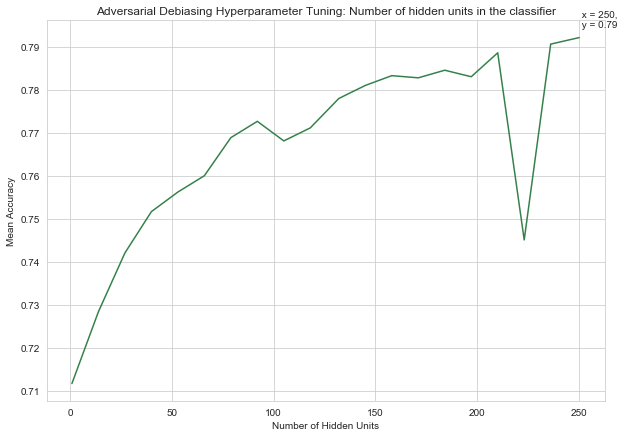

In [32]:
plot_params(param = 'Number of Hidden Units', param_data = units, metric = 'Mean Accuracy',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Number of hidden units in the classifier', 
    file_name = 'debiased_params_units.png', best_x = 250, best_y = 0.794638)

In [33]:
session.close()
tf.reset_default_graph()
session = tf.Session()

In [39]:
ad = AdversarialDebiasing(privileged_groups = privileged_groups, 
    unprivileged_groups = unprivileged_groups, scope_name = 'debiased_classifier', 
    debias = True, sess = session, num_epochs = 100, batch_size = 32,
    classifier_num_hidden_units = 250, adversary_loss_weight = 0.58)
debiased_scaler = StandardScaler()
debiased_train = original_train.copy()
debiased_train.features = debiased_scaler.fit_transform(debiased_train.features)

In [40]:
ad = ad.fit(debiased_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.659894; batch adversarial loss: 0.658015
epoch 1; iter: 0; batch classifier loss: 0.548801; batch adversarial loss: 0.820430
epoch 2; iter: 0; batch classifier loss: 0.782227; batch adversarial loss: 0.860148
epoch 3; iter: 0; batch classifier loss: 1.048669; batch adversarial loss: 0.888971
epoch 4; iter: 0; batch classifier loss: 0.785303; batch adversarial loss: 0.754464
epoch 5; iter: 0; batch classifier loss: 0.806182; batch adversarial loss: 0.807162
epoch 6; iter: 0; batch classifier loss: 0.756588; batch adversarial loss: 0.701786
epoch 7; iter: 0; batch classifier loss: 0.538585; batch adversarial loss: 0.689062
epoch 8; iter: 0; batch classifier loss: 0.635695; batch adversarial loss: 0.718978
epoch 9; iter: 0; batch classifier loss: 0.619698; batch adversarial loss: 0.636675
epoch 10; iter: 0; batch classifier loss: 0.5

In [41]:
debiased_val = original_val.copy()
debiased_val.features = debiased_scaler.transform(debiased_val.features)
y_train_preds_db = ad.predict(debiased_train).scores

In [42]:
AD_bal_acc_arr = []
AD_disp_imp_arr = []
AD_avg_odds_diff_arr = []
AD_eq_opp_diff_arr = []
AD_outcome_unfair_arr = []
AD_acc_equal_arr = []

In [43]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    y_val_preds = (y_train_preds_db[:, pos_ind] > thresh).astype(np.float64)
    debiased_test_preds = debiased_train.copy()
    debiased_test_preds.labels = y_val_preds

    ad_metric_test = compute_metrics(debiased_train, debiased_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    ad_class_metric_test = ClassificationMetric(debiased_train, debiased_test_preds, \
        unprivileged_groups, privileged_groups)
    
    AD_bal_acc_arr.append(ad_metric_test['Balanced accuracy'])
    AD_avg_odds_diff_arr.append(ad_metric_test['Average odds difference'])
    AD_disp_imp_arr.append(ad_metric_test['Disparate impact'])
    AD_eq_opp_diff_arr.append(ad_metric_test['Equal opportunity difference'])
    AD_outcome_unfair_arr.append(ad_class_metric_test.false_discovery_rate_difference() \
        + ad_class_metric_test.false_positive_rate_difference())
    AD_acc_equal_arr.append((ad_class_metric_test.true_positive_rate(privileged = False) + \
        ad_class_metric_test.true_negative_rate(privileged = False)) - \
            (ad_class_metric_test.true_positive_rate(privileged = True) + \
                ad_class_metric_test.true_negative_rate(privileged = True)))

#### Predictions from the original testing data

 14%|█▍        | 14/100 [00:00<00:00, 134.07it/s]

Classification threshold used: 0.5643


divide by zero encountered in double_scalars
 77%|███████▋  | 77/100 [00:00<00:00, 117.41it/s]

Balanced accuracy = 0.3420
Statistical parity difference = -0.0223
Disparate impact = 0.9615
Average odds difference = -0.0611
Equal opportunity difference = -0.0980
Theil index = 0.4229


100%|██████████| 100/100 [00:00<00:00, 123.59it/s]


In [47]:
save_to_json(filename = 'AD_bal_acc_arr.json', data = AD_bal_acc_arr)
save_to_json(filename = 'AD_disp_imp_arr.json', data = AD_disp_imp_arr)
save_to_json(filename = 'AD_avg_odds_diff_arr.json', data = AD_avg_odds_diff_arr)
save_to_json(filename = 'AD_eq_opp_diff_arr.json', data = AD_eq_opp_diff_arr)
save_to_json(filename = 'AD_outcome_unfair_arr.json', data = AD_outcome_unfair_arr)
save_to_json(filename = 'AD_acc_equal_arr.json', data = AD_acc_equal_arr)

In [44]:
AD_bal_acc = np.interp(best_class_thresh, class_thresh_arr, AD_bal_acc_arr)
AD_acc_equal = np.interp(best_class_thresh, class_thresh_arr, AD_acc_equal_arr)
AD_disp_imp = np.interp(best_class_thresh, class_thresh_arr, AD_disp_imp_arr)
AD_out_unf = np.interp(best_class_thresh, class_thresh_arr, AD_outcome_unfair_arr)
AD_avg_odds = np.interp(best_class_thresh, class_thresh_arr, AD_avg_odds_diff_arr)
AD_eq_odds = np.interp(best_class_thresh, class_thresh_arr, AD_eq_opp_diff_arr)

In [45]:
AD_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Adversarial Debiasing': [AD_bal_acc, AD_acc_equal, AD_disp_imp, AD_out_unf, AD_avg_odds, AD_eq_odds]}
AD_results_df = pd.DataFrame(AD_results)
AD_results_df

,Metric,Adversarial Debiasing
0,Balanced Accuracy,0.342027
1,Accuracy Equality,-0.073757
2,Disparate Impact,0.961528
3,Outcome Unfairess,0.150370
4,Average Odds Difference,-0.061080
5,Equal Opportunity Difference,-0.097959


In [46]:
df_to_json(filename = 'AD_results.json', df = AD_results_df)